In [1]:
%pylab inline
import calin.math.hex_array

Populating the interactive namespace from numpy and matplotlib


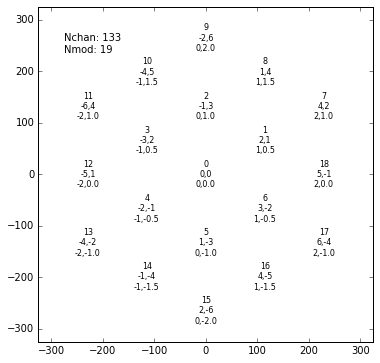

In [34]:
figure(figsize=[6,6])
spacing = 50
rad = 5.5*spacing
axis(asarray([-1,1,-1,1])*(rad+spacing))
nchan = 0
nmod = 0
u1,v1 = calin.math.hex_array.cluster_hexid_to_center_uv(1,1)
x1,y1 = calin.math.hex_array.uv_to_xy(u1,v1)
rot = arctan2(-y1,x1) + 30/180*pi
crot = cos(rot)
srot = sin(rot)
for i in range(0,calin.math.hex_array.ringid_to_nsites_contained(2)):
    uc,vc = calin.math.hex_array.cluster_hexid_to_center_uv(i,1)
    xxc,yyc = calin.math.hex_array.uv_to_xy(uc,vc)
    xc = spacing*(crot*xxc - srot*yyc)
    yc = spacing*(crot*yyc + srot*xxc)
    if(xc*xc+yc*yc > rad*rad):
        continue
    text(xc,yc,'%d\n%d,%d\n%d,%.1f'%(nmod,uc,vc,(vc+3*uc)/7,(vc+uc-2*(vc+3*uc)/7)/2),ha='center',va='center',fontsize=8)
    nchan=nchan+7
    nmod = nmod+1
#gca().add_patch(Circle((0,0),rad,color='r',fill=False))
text(-rad,rad,'Nchan: %d\nNmod: %d\n'%(nchan,nmod),va='top')